## Model Development & Performance

In [ ]:
import pandas as pd
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

#### Data Loading

In [ ]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')

We will start with classic models to evaluate their effectiveness. As a first step, we will attempt to predict the number of people without power. Initially, we will remove columns that are not relevant to our task, such as time-related data and precise location identifiers (e.g., county name and code). The remaining data will be transformed and prepared for modeling.

### XGBRegressor

In [4]:
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind',]

In [5]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division']
event_features = [col for col in df.columns if col in event_names]

X = df[numeric_features + categorical_features + event_features]
y = df[target]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

event_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('event', event_transformer, event_features)
])

In [8]:
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

In [29]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    verbosity=1,
    colsample_bytree=0.3,
    early_stopping_rounds=20,
    random_state=42
)

xgb.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    verbose=True
)

[0]	validation_0-rmse:1479.44628
[1]	validation_0-rmse:1478.76089
[2]	validation_0-rmse:1478.22730
[3]	validation_0-rmse:1477.31792
[4]	validation_0-rmse:1476.28734
[5]	validation_0-rmse:1476.25554
[6]	validation_0-rmse:1474.07049
[7]	validation_0-rmse:1473.13567
[8]	validation_0-rmse:1472.70791
[9]	validation_0-rmse:1472.28972
[10]	validation_0-rmse:1471.00776
[11]	validation_0-rmse:1470.85316
[12]	validation_0-rmse:1469.18733
[13]	validation_0-rmse:1468.38280
[14]	validation_0-rmse:1468.30442
[15]	validation_0-rmse:1467.59923
[16]	validation_0-rmse:1465.09802
[17]	validation_0-rmse:1464.53772
[18]	validation_0-rmse:1464.02536
[19]	validation_0-rmse:1463.91608
[20]	validation_0-rmse:1463.74474
[21]	validation_0-rmse:1463.73358
[22]	validation_0-rmse:1462.90520
[23]	validation_0-rmse:1461.81601
[24]	validation_0-rmse:1461.37282
[25]	validation_0-rmse:1461.28740
[26]	validation_0-rmse:1461.27876
[27]	validation_0-rmse:1461.05672
[28]	validation_0-rmse:1461.04833
[29]	validation_0-rmse:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [12]:
# Model XGBoost
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=2
)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.001, 0.5),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1,
    random_state=42
)

random_search.fit(X_train_proc, y_train)

with open("random_search_results.pkl", "wb") as f:
    pickle.dump(random_search, f)

print("✅ Zapisano RandomizedSearchCV do pliku random_search_results.pkl")
print("✅ Najlepsze parametry:", random_search.best_params_)
print("📉 Najlepszy neg-RMSE (cross-val):", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  54.1s
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  49.4s
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  44.3s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417065; total time=  56.7s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417065; total time=  52.6s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417

In [15]:
best_model = random_search.best_estimator_
joblib.dump(best_model, "../models/xgb_model.pkl")
print("✅ Zapisano najlepszy model XGBoost do best_xgb_model.pkl")

✅ Zapisano najlepszy model XGBoost do best_xgb_model.pkl


In [19]:
y_pred = best_model.predict(X_val_proc)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 1414.8726
MAE: 91.6789
R²: 0.0882


### Time Series Modelling

Another model we are testing is the SARIMAX model, which is used for time series forecasting. It is particularly important as it allows us to account for both seasonal effects and exogenous variables. Since our data is aggregated on a daily basis, we can evaluate how well this model performs with such a frequency.

This model takes time as an input, but time is not unique in our dataset, since we are analyzing power outages separately for each county—this means that the same dates appear multiple times. The idea is to first test the model on five randomly selected counties to evaluate its performance.

In [258]:
random_counties = np.random.choice(df['CountyName'].unique(), size=5, replace=False).tolist()

In [274]:
df_dict = {}
for r in random_counties:
    df_subset = df[df['CountyName'] == r]
    state_random = np.random.choice(df_subset['StateName'].unique(), size=1)[0]
    df_subset = df_subset[df_subset['StateName'] == state_random]
    df_dict[r] = df_subset
    

We are now transforming or removing the following columns:

- FIPS, Month, Year, Region, Division, lng_rad, lat_rad, StateName, CountyName – these columns contain only one unique value per county and therefore do not add value for modeling.

- Month and Year – these will be removed since we will use the date column to model seasonality.

- ValidDataFlag 


The following transformations will be applied:

- season – this is a categorical variable and will be one-hot encoded into binary features.

Finally, we will sort the data by the date column and set it as the index of the DataFrame.

In [275]:
for key, d in df_dict.items():
    d = d.drop(columns=['Fips', 'Month', 'Year', 'Region', 'Division',
                          'lng_rad', 'lat_rad', 'StateName', 'CountyName', 'ValidDataFlag', 'CustomersOutEstimate'])

    d = pd.get_dummies(d, columns=['Season'])

    #d['Date'] = pd.to_date(d['Date'])
    df['Date'] = pd.to_datetime(df['Date'])
    d = d.sort_values('Date')
    d.set_index('Date', inplace=True)

    d = d.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)


    df_dict[key] = d

Since we have two possible target columns (PercentCustomersOut and CustomersOut), we will compare the results obtained using each of them to evaluate which one yields better performance.

####  CustomersOut as prediction

In [276]:
import copy
dict_customers_out = copy.deepcopy(df_dict)

In [277]:
for key, d in dict_customers_out.items():
    d = d.drop(columns=['PercentCustomersOut'])
    dict_customers_out[key] = d

In [278]:
for key, d in dict_customers_out.items():
    print(len(d))

3393
3293
3287
3291
3287


We will split the DataFrame into training and testing sets. Since our goal is to make early predictions, we will use the most recent year (i.e., the last 365 days) as the test set.

In [279]:
for key, d in dict_customers_out.items():
    train = d.iloc[:-365]
    test = d.iloc[-365:]

    dict_customers_out[key] = [d, train, test]

The Augmented Dickey-Fuller (ADF) Test is a statistical test used to determine whether a time series is stationary or not. A stationary series has constant statistical properties such as mean, variance, and autocorrelation over time. The ADF test works by testing the null hypothesis that a unit root is present in the time series, which would imply the series is non-stationary (i.e., it has a trend or random walk behavior). If the test statistic is significantly negative and the p-value is low (usually less than 0.05), we reject the null hypothesis and conclude that the series is stationary.

In [280]:
for key, d in dict_customers_out.items():
    result = adfuller(d[1]['CustomersOut'])
    print('ADF Statistics for ' + key + ': ' + str(result[0]))
    print('p value for ' + key + ': ' + str(result[1]))
    print('------------------------------------------------')

ADF Statistics for Clinton: -44.55461654616125
p value for Clinton: 0.0
------------------------------------------------
ADF Statistics for Harris: -18.35053830348232
p value for Harris: 2.2369827069817784e-30
------------------------------------------------
ADF Statistics for Sawyer: -31.862051740802215
p value for Sawyer: 0.0
------------------------------------------------
ADF Statistics for Vermilion: -45.70890934788436
p value for Vermilion: 0.0
------------------------------------------------
ADF Statistics for Berks: -23.8565564079907
p value for Berks: 0.0
------------------------------------------------


#### Interpretation:

All p-values are smaller than 0.05, which means that for each of these counties, we can reject the null hypothesis of non-stationarity in the time series. Practically, this indicates that the data is stationary and can be used for analysis, modeling, and forecasting without the need for additional transformations such as removing trends or seasonality.



- All the values of the ADF test statistics are negative, which indicates that we can confidently reject the null hypothesis of non-stationarity. This strong negative result suggests that the time series for all counties is likely stationary, meaning there is no significant trend or unit root present.

### ACF and PACF Plots

**Purpose:**
- **ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)** plots are used to analyze the autocorrelations in a time series.
- ACF measures the correlation between a time series and its lagged values over different periods.
- PACF shows the partial correlation, which measures the correlation between the series and its lag, after removing the effects of shorter lags.

- **ACF Plot:** If the ACF shows a sharp cutoff, it suggests an MA process of a certain order.
- **PACF Plot:** A sharp cutoff in the PACF plot indicates the order of the AR component.


In [281]:
def plot_acf_pacf(dict, lag, col='CustomersOut'):
    plt.figure(figsize=(14, 10))

    for i, (key, d) in enumerate(dict.items(), 1):
        train = d[1]
        plt.subplot(5, 2, 2 * i - 1) 
        plot_acf(train[col], lags=lag, ax=plt.gca())
        plt.title(f"ACF - {key}")

        plt.subplot(5, 2, 2 * i) 
        plot_pacf(train[col], lags=lag, ax=plt.gca(), method='ywm')
        plt.title(f"PACF - {key}")

    plt.tight_layout()
    plt.show()


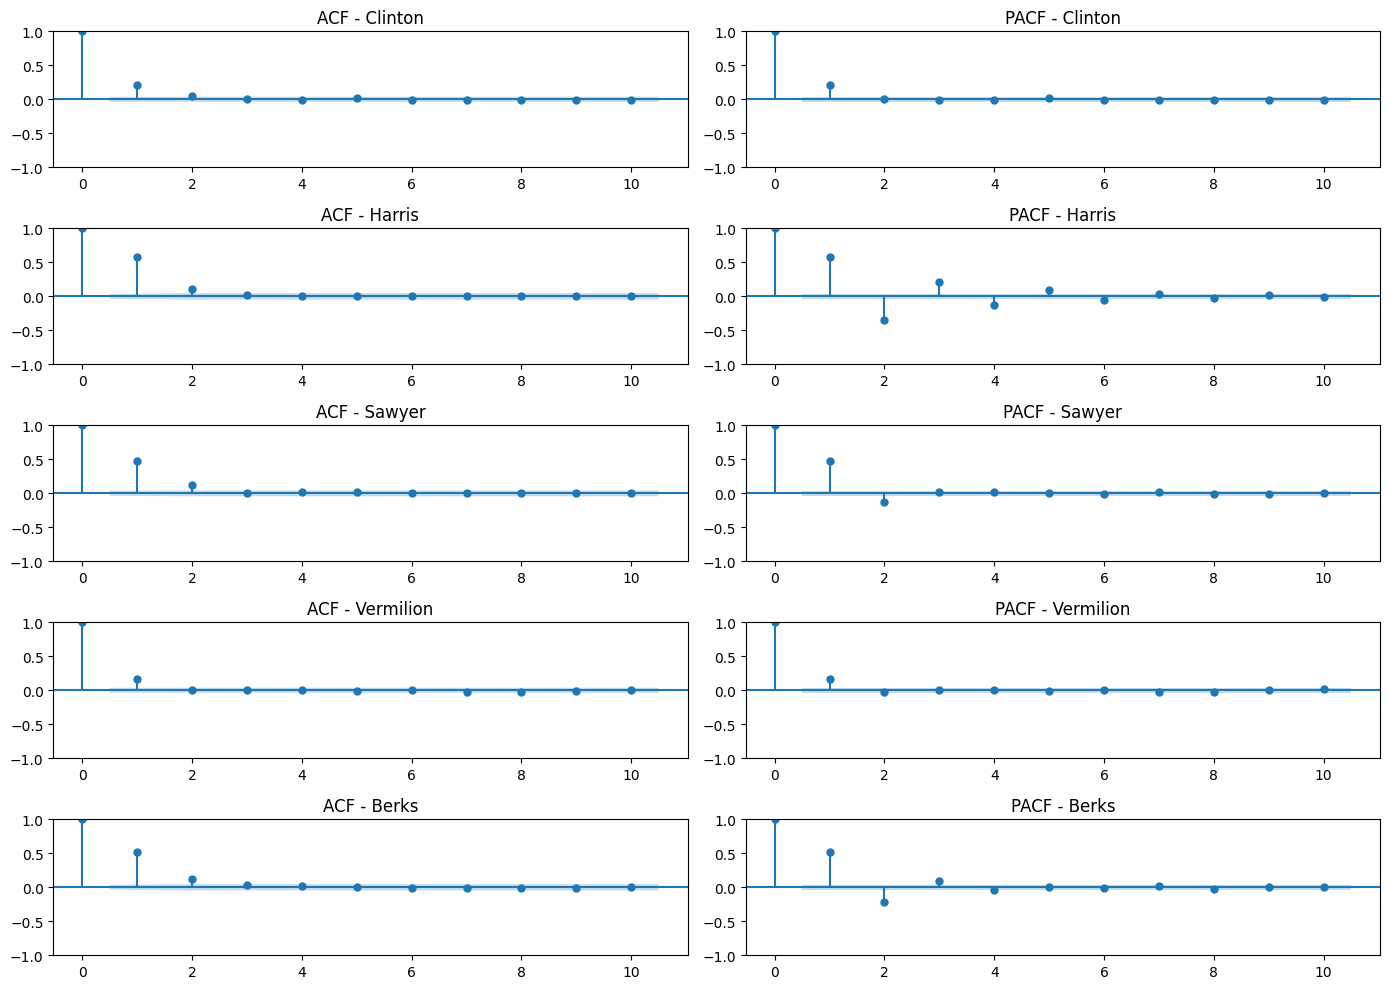

In [282]:
plot_acf_pacf(dict_customers_out, 10)

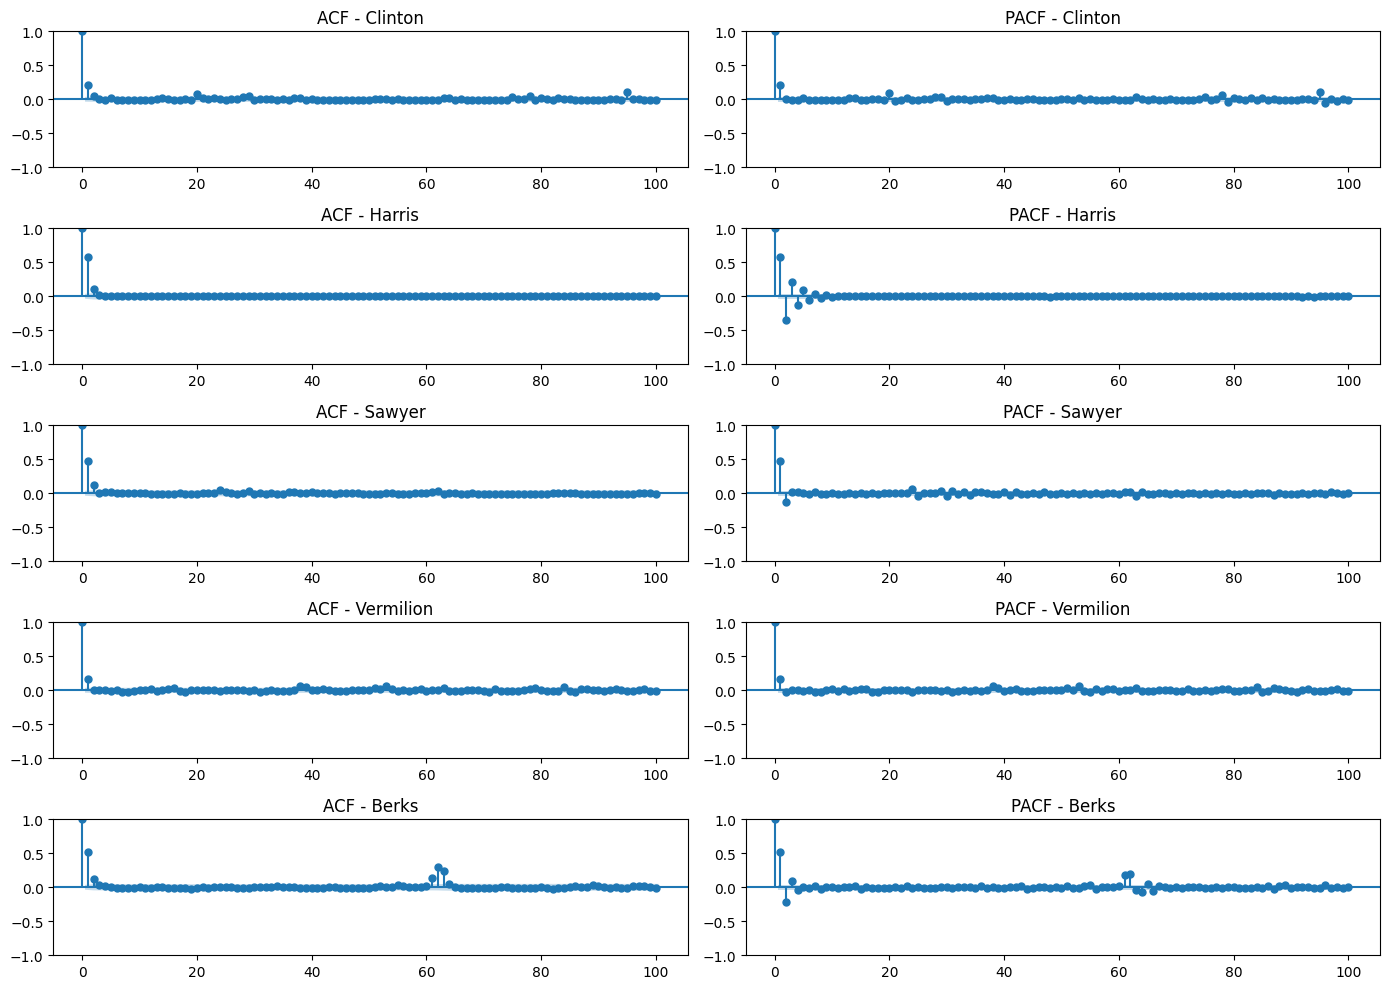

In [283]:
plot_acf_pacf(dict_customers_out, 100)

- In this case, for all counties, the ACF plots show a sharp drop after a few lags. This suggests that most of the correlation in the series is captured by the initial few lags. After that, the correlation quickly diminishes, indicating short-range dependence
- the series has little memory
- PACF has a significant peak at lag 1, suggesting that an AR(1) process might also be a reasonable starting point for these counties

In [284]:
q = 1
p = 1
dd = 0  ## dane stacjonarne

In [285]:
for key, d in dict_customers_out.items():
    train = d[1]
    test = d[2]
    test = test[~test.index.duplicated()]
    train = train[~train.index.duplicated()]

    print(train.index[-1])

    model = SARIMAX(
    train['CustomersOut'],
    exog=train.drop(columns='CustomersOut'),
    order=(p, dd, q), 
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
    )

    results = model.fit()
    forecast = results.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns='CustomersOut'))

    dict_customers_out[key].append(results)
    dict_customers_out[key].append(forecast)



2023-01-15 00:00:00
2022-12-31 00:00:00
2022-12-31 00:00:00
2022-12-31 00:00:00
2022-12-31 00:00:00


In [286]:
dict_customers_out['Clinton'][3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           CustomersOut   No. Observations:                 2937
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -17245.541
Date:                Sat, 19 Apr 2025   AIC                          34589.082
Time:                        14:20:08   BIC                          34882.320
Sample:                    01-01-2015   HQIC                         34694.676
                         - 01-15-2023                                         
Covariance Type:                  opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Astronomical Low Tide   -3.423e-07         -0        inf      0.000   -3.42e-07   -3.42e-07
Extreme Cold/Wind Chill    35.7609     85.817      0.417      0.677    -132.438     203.959
Flood                      -1.4695     44.952     -0.033      0.974     -89.573      86.634
Winter Weather             -4.2256    151.482     -0.028      0.978    -301.124     292.673
TotalDamages            -2.461e-05   2.99e-05     -0.824      0.410   -8.31e-05    3.39e-05
Wildfire                -6.209e-09   6.57e-08     -0.094      0.925   -1.35e-07    1.23e-07
Heavy Rain                 -4.6117      0.049    -93.651      0.000      -4.708      -4.515
Cold/Wind Chill         -2.585e-09        nan        nan        nan         nan         nan
Dense Fog               -9.074e-10        nan        nan        nan         nan         nan
Frost/Freeze               -5.8654      1.148     -5.109      0.000      -8.116      -3.615
Strong Wind                -0.8450    226.788     -0.004      0.997    -445.341     443.651
Lake-Effect Snow        -1.854e-10        nan        nan        nan         nan         nan
Funnel Cloud               -5.5211    545.399     -0.010      0.992   -1074.483    1063.441
Flash Flood                -5.1864     21.415     -0.242      0.809     -47.158      36.786
Heavy Snow                 -2.7002    290.203     -0.009      0.993    -571.488     566.088
Ice Storm                  -3.6812    124.295     -0.030      0.976    -247.295     239.933
Thunderstorm Wind           2.9915      4.035      0.741      0.458      -4.916      10.900
Avalanche                1.048e-11   1.13e-12      9.267      0.000    8.26e-12    1.27e-11
Excessive Heat             17.2481     33.422      0.516      0.606     -48.257      82.753
Coastal Flood            8.388e-12        nan        nan        nan         nan         nan
Storm Surge/Tide         1.355e-11   5.58e-13     24.282      0.000    1.25e-11    1.46e-11
Sleet                      -6.3395     79.540     -0.080      0.936    -162.235     149.556
Debris Flow             -8.369e-12        nan        nan        nan         nan         nan
Winter Storm               37.7018      9.647      3.908      0.000      18.795      56.609
TotalPeopleInjuries       -11.7556     39.378     -0.299      0.765     -88.935      65.424
Magnitude                  -2.2872      4.044     -0.566      0.572     -10.213       5.639
Tropical Storm           6.401e-11        nan        nan        nan         nan         nan
Dust Storm               1.419e-10        nan        nan        nan         nan         nan
Drought                     4.4150     70.747      0.062      0.950    -134.246     143.076
Blizzard                   72.7777    104.225      0.698      0.485    -131.500     277.055
Lightning               -7.316e-14   7.93e-14     -0.922      0.356   -2.29e-13    8.23e-14
Tornado                    -4.2241     10.589     -0.399      0.690     -24.978      16.530
Hail                 

In [289]:
def plot_forecasts(data_dict, col='CustomersOut', maxlim=5000):

    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20), sharex=True)
    fig.subplots_adjust(hspace=0.4)
    
    for ax, (key, d) in zip(axes, data_dict.items()):
        train = d[1]
        test = d[2]
        forecast = d[4]
        test = test[~test.index.duplicated()]
        train = train[~train.index.duplicated()]
        
        ax.plot(train.index, train[col], label='Trening', color='blue')
        ax.plot(test.index, test[col], label='Rzeczywiste dane', color='green')
        ax.plot(test.index, forecast, label='Prognozy', color='red', alpha=0.5)
        ax.set_title(f'Wykres: {key}')
        ax.set_ylim(0, maxlim)
        ax.legend()

    plt.xlabel("Data")
    plt.tight_layout()
    plt.show()


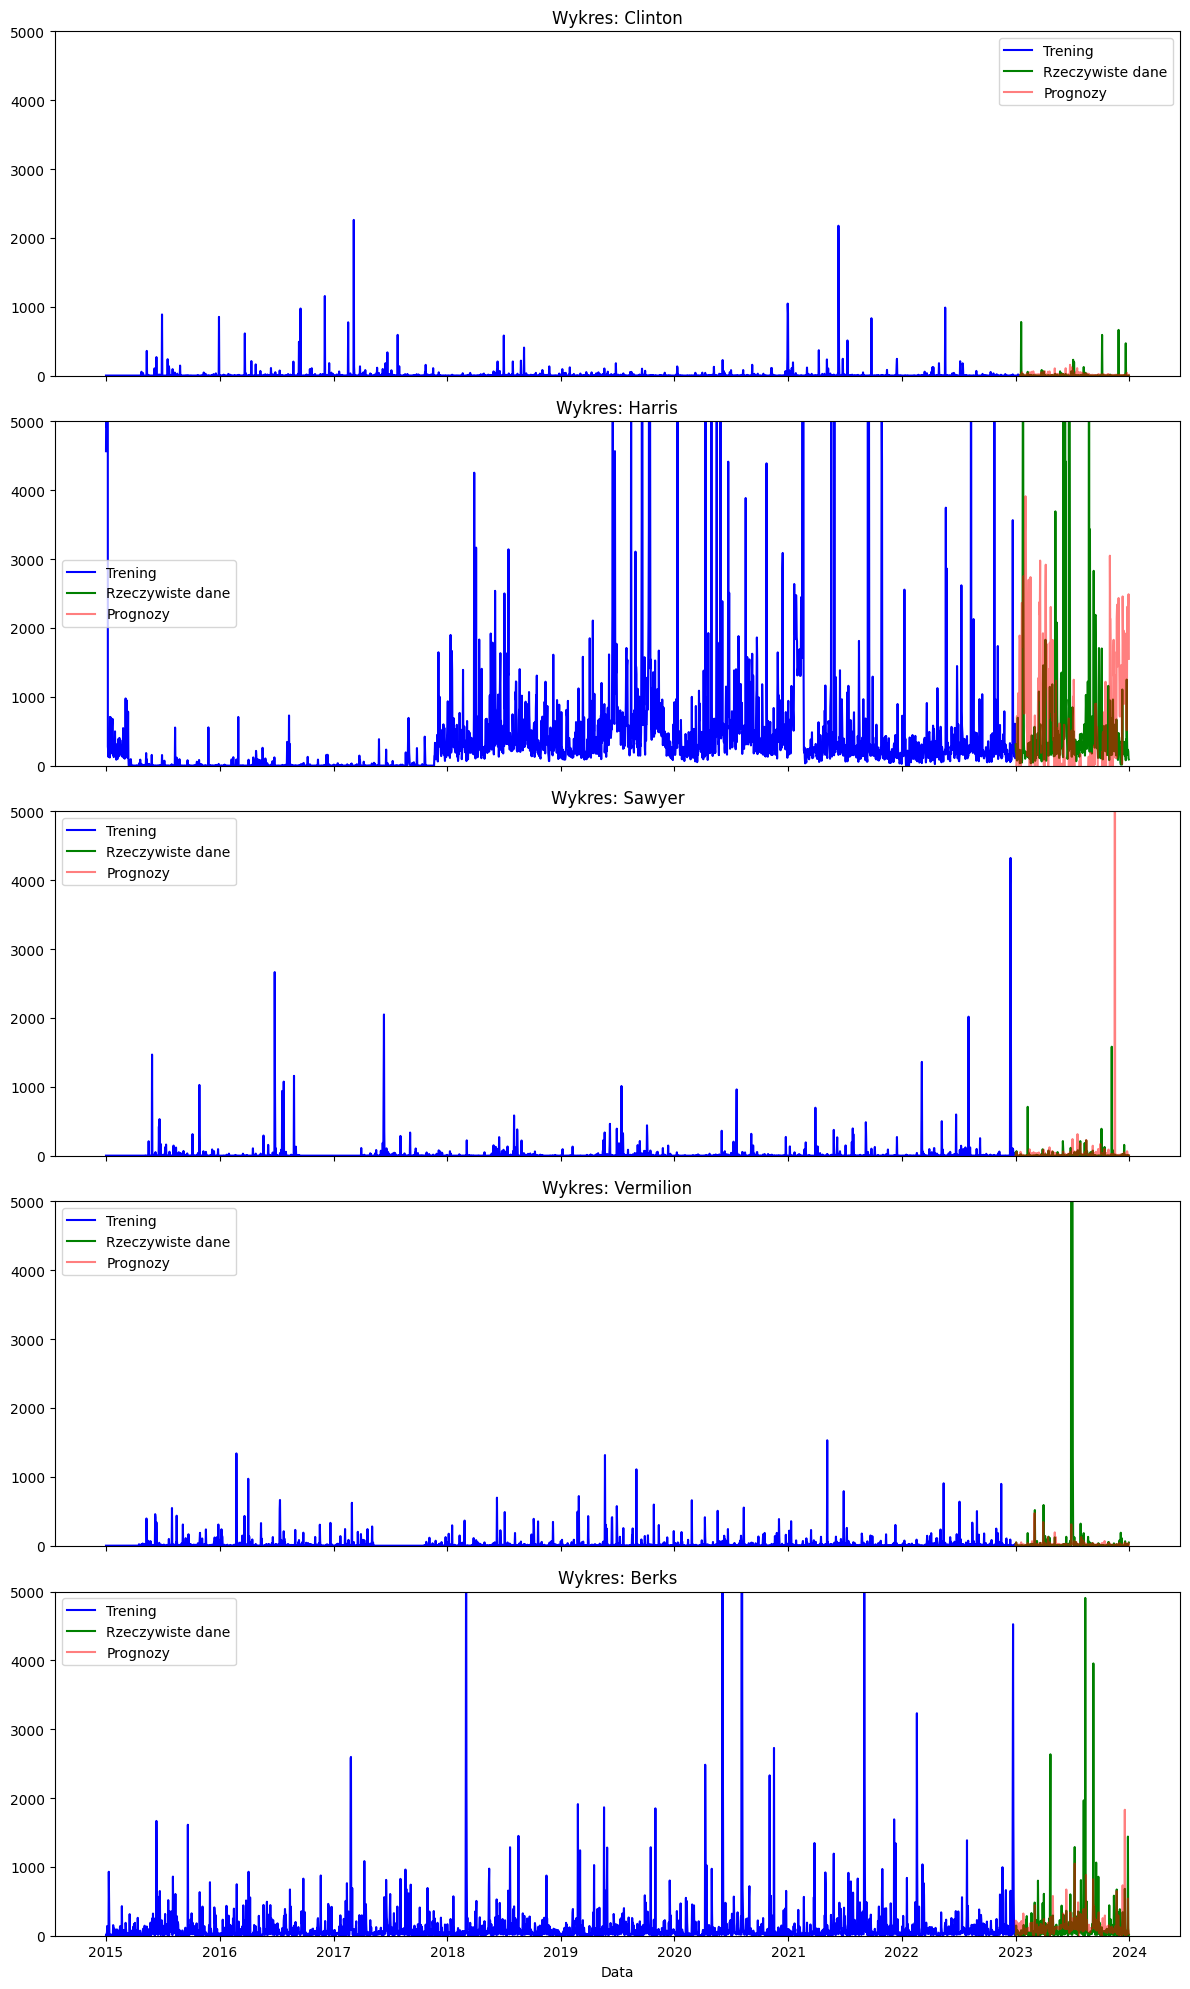

In [290]:
plot_forecasts(dict_customers_out)

In [291]:
def evaluate_forecasts(data_dict, col='CustomersOut'):
    results = []

    for key, d in data_dict.items():
        test = d[2]
        forecast = d[4]

        test = test[~test.index.duplicated()]
        forecast = forecast[~forecast.index.duplicated()]

        y_true = test.loc[forecast.index, col]
        y_pred = forecast

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        results.append({
            '  ': key,
            'MAE': round(mae, 2),
            'MSE': round(mse, 2),
            'R²': round(r2, 4)
        })

    return pd.DataFrame(results)

In [292]:
evaluation = evaluate_forecasts(dict_customers_out)

In [293]:
evaluation

,,MAE,MSE,R²
0,Clinton,21.24,5201.83,-0.0679
1,Harris,1224.26,8558289.46,-0.2044
2,Sawyer,63.34,466214.11,-48.8682
3,Vermilion,196.98,2630854.59,-0.0032
4,Berks,140.50,152555.73,0.0924


#### PercentCustomersOut as prediction

In [294]:
dict_percent = copy.deepcopy(df_dict)

In [295]:
for key, d in dict_percent.items():
    d = d.drop(columns=['CustomersOut'])
    dict_percent[key] = d

In [296]:
for key, d in dict_percent.items():
    train = d.iloc[:-365]
    test = d.iloc[-365:]

    dict_percent[key] = [d, train, test]

In [297]:
for key, d in dict_percent.items():
    result = adfuller(d[1]['PercentCustomersOut'])
    print('ADF Statistics for ' + key + ': ' + str(result[0]))
    print('p value for ' + key + ': ' + str(result[1]))
    print('------------------------------------------------')

ADF Statistics for Clinton: -44.55461654616124
p value for Clinton: 0.0
------------------------------------------------
ADF Statistics for Harris: -18.3505383034823
p value for Harris: 2.2369827069817143e-30
------------------------------------------------
ADF Statistics for Sawyer: -31.862051740802237
p value for Sawyer: 0.0
------------------------------------------------
ADF Statistics for Vermilion: -45.708909347884344
p value for Vermilion: 0.0
------------------------------------------------
ADF Statistics for Berks: -23.856556407990677
p value for Berks: 0.0
------------------------------------------------


All p-values are below 0.05, allowing us to reject the null hypothesis of non-stationarity. This means the data is stationary and can be used for analysis, modeling, and forecasting without further transformations like removing trends or seasonality.



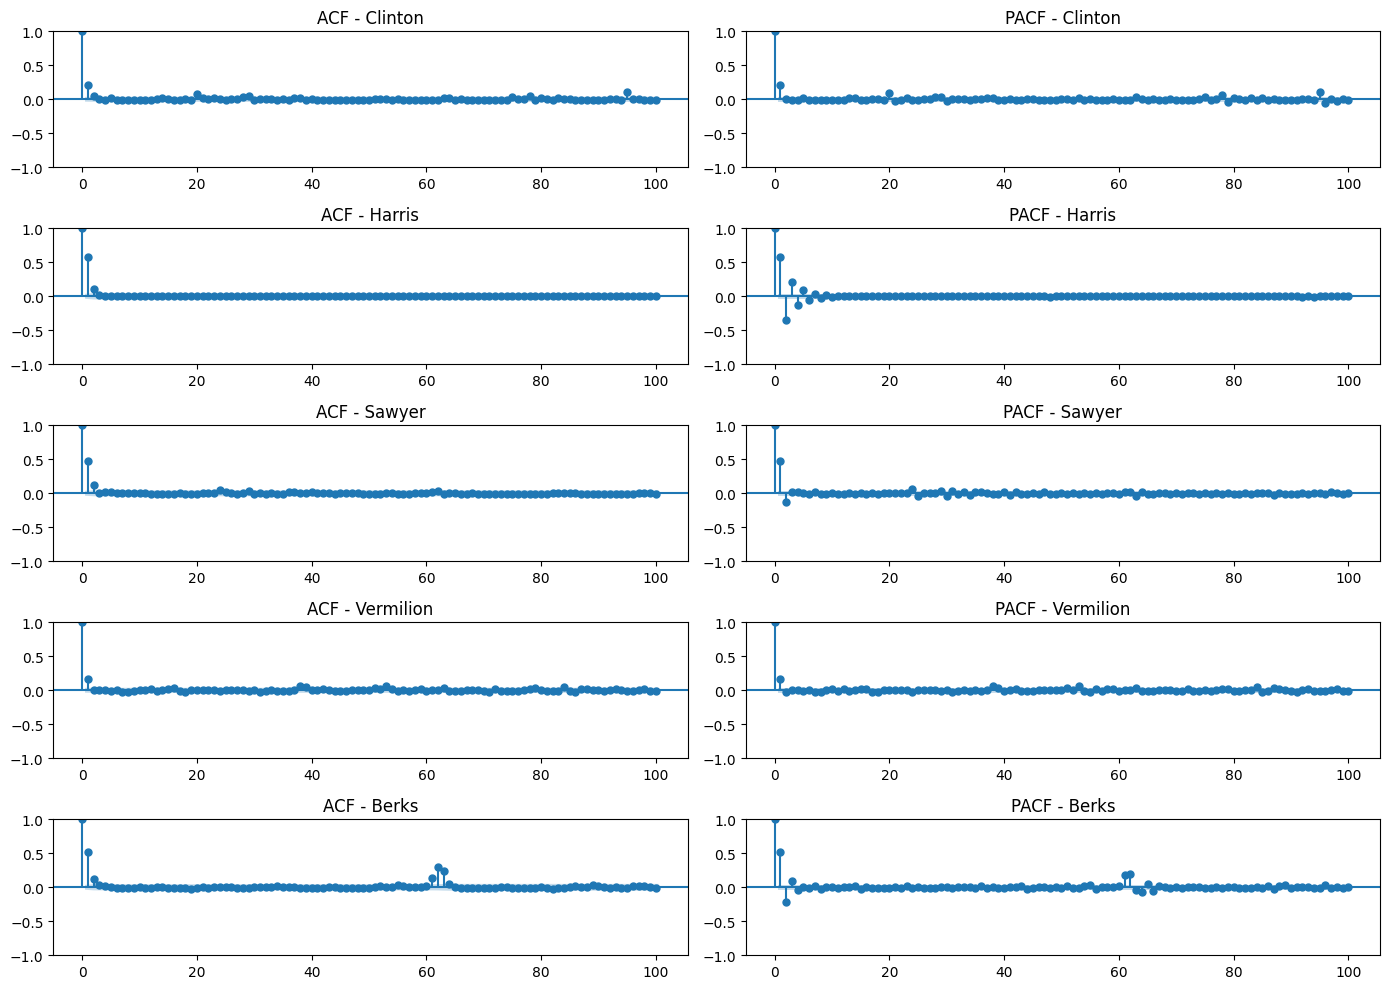

In [298]:
plot_acf_pacf(dict_percent, 100, 'PercentCustomersOut')

In [299]:
for key, d in dict_percent.items():
    train = d[1]
    test = d[2]
    test = test[~test.index.duplicated()]
    train = train[~train.index.duplicated()]

    model = SARIMAX(
        train['PercentCustomersOut'],
        exog=train.drop(columns='PercentCustomersOut'),
        order=(p, dd, q), 
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit()
    forecast = results.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns='PercentCustomersOut'))

    dict_percent[key].append(results)
    dict_percent[key].append(forecast)



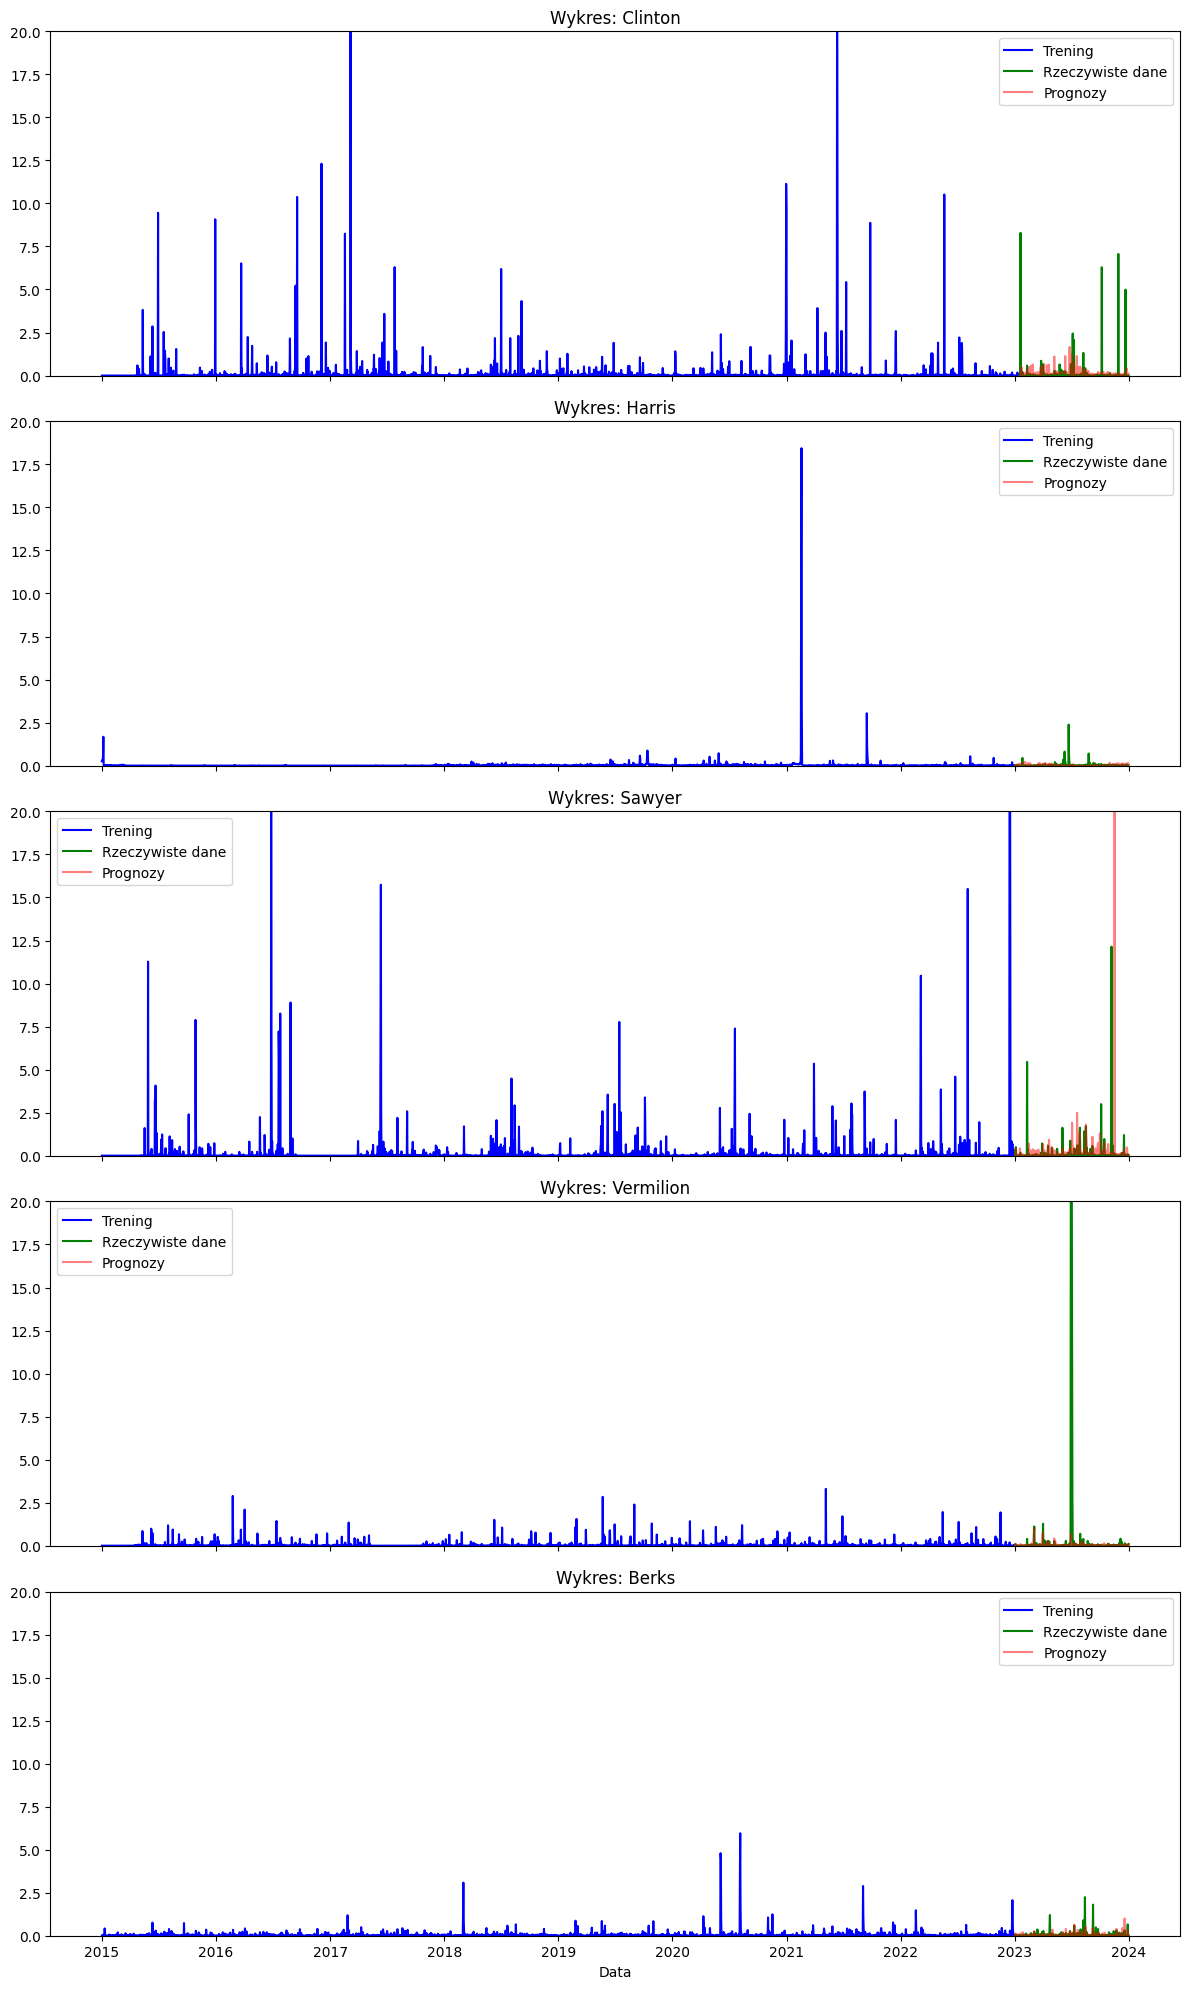

In [300]:
plot_forecasts(dict_percent, col='PercentCustomersOut', maxlim=20)

In [301]:
evaluate_forecasts(dict_percent, 'PercentCustomersOut')

,,MAE,MSE,R²
0,Clinton,0.23,0.60,-0.0792
1,Harris,0.07,0.03,-0.2044
2,Sawyer,0.49,27.53,-48.9433
3,Vermilion,0.42,12.23,-0.0032
4,Berks,0.06,0.03,0.0818
